# Modelo de Classificação para Diagnóstico de Diabetes Baseado em Redes Neurais (Multilayer Perceptron - MLP)

- **Autor:** João Gabriel Galvão de Carvalho Argento  
- **Disciplina:** Redes Neurais
- **Instituição:** Universidade do Estado do Rio de Janeiro (UERJ)


# Preparando o Ambiente

In [8]:
pip install bayesian-optimization

In [9]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold, train_test_split # Added train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.datasets import make_classification # Importing make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score # Importing evaluation metrics
import tensorflow as tf
from bayes_opt import BayesianOptimization
import heapq

In [10]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Análise Exploratória de Dados

In [11]:
df = pd.read_csv('/content/drive/MyDrive/Estatística (Faculdade)/5 Período/Redes Neurais/Trabalho P1/pima.csv', sep = ';', header=None)
display(df.head())
df.info()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       768 non-null    int64  
 1   1       768 non-null    int64  
 2   2       768 non-null    int64  
 3   3       768 non-null    int64  
 4   4       768 non-null    int64  
 5   5       768 non-null    float64
 6   6       768 non-null    float64
 7   7       768 non-null    int64  
 8   8       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Esta base de dados contém informações médicas para prever se uma pessoa tem diabetes.

Como observado, as colunas deste conjunto de dados não têm nomes. Por isso, o código a seguir as nomeia, facilitando a compreensão intuitiva e a interpretação das análises futuras.

In [12]:
colunas = ['gestacoes','glicose','pressao_arterial','espessura_pele','insulina','imc','funcao_pedigree_diabetes','idade','outcome']
df.columns = colunas
df.columns

Index(['gestacoes', 'glicose', 'pressao_arterial', 'espessura_pele',
       'insulina', 'imc', 'funcao_pedigree_diabetes', 'idade', 'outcome'],
      dtype='object')

In [13]:
display(df.head())

,gestacoes,glicose,pressao_arterial,espessura_pele,insulina,imc,funcao_pedigree_diabetes,idade,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gestacoes                 768 non-null    int64  
 1   glicose                   768 non-null    int64  
 2   pressao_arterial          768 non-null    int64  
 3   espessura_pele            768 non-null    int64  
 4   insulina                  768 non-null    int64  
 5   imc                       768 non-null    float64
 6   funcao_pedigree_diabetes  768 non-null    float64
 7   idade                     768 non-null    int64  
 8   outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Conforme as informações acima, a base inclui dados como:
- **Gestações**: Número de vezes em que a pessoa esteve grávida.
- **Glicose**: Concentração de glicose no plasma 2 horas após um teste de tolerância à glicose oral.
- **Pressão Arterial**: Pressão arterial diastólica (em mm Hg).
- **Espessura da Pele**: Espessura da dobra cutânea do tríceps (em mm).
- **Insulina**: Nível de insulina no soro 2 horas após um teste (em mu U/ml).
- **IMC**: Índice de Massa Corporal (peso em kg / (altura em m)^2).
- **Função Pedigree Diabetes**: Uma função que avalia o histórico familiar de diabetes.
- **Idade**: Idade da pessoa (em anos).
- **Outcome**: Variável de classe que indica se a pessoa tem diabetes (1) ou não (0).

Para iniciar a análise das características das variáveis numéricas da base de dados, o código a seguir visualiza a distribuição de cada uma delas por meio de histogramas.

=== DISTRIBUIÇÕES DAS VARIÁVEIS ===


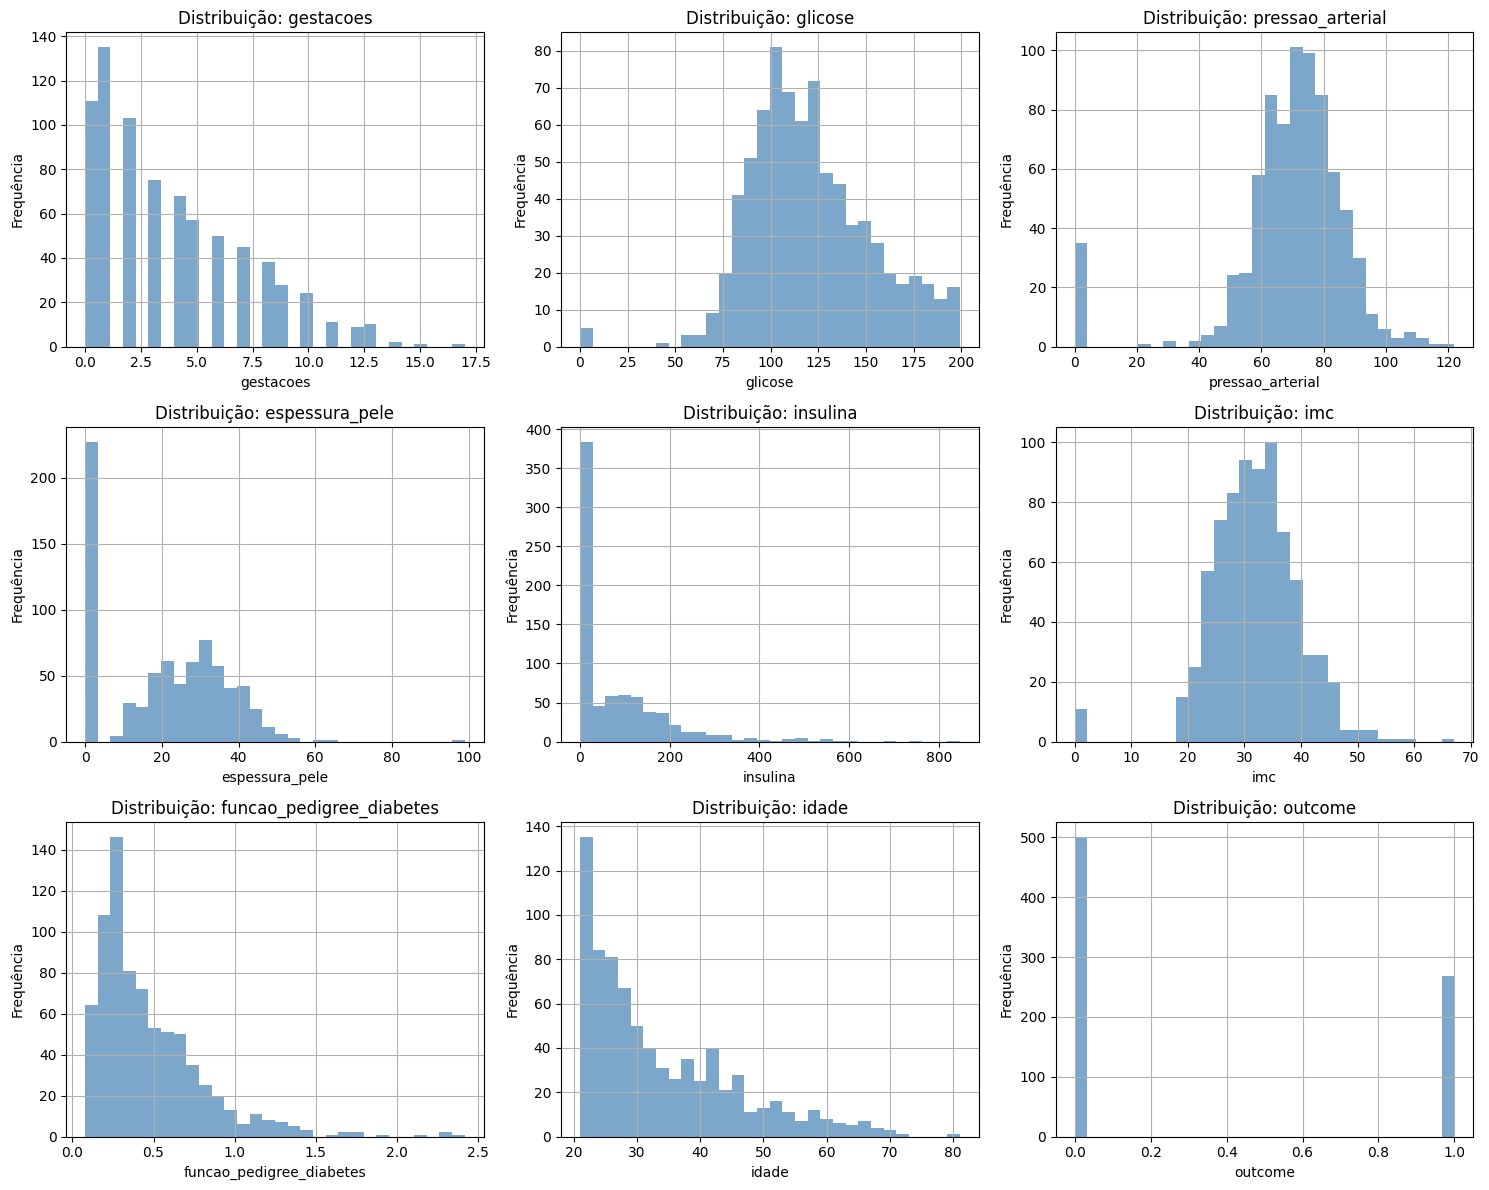

In [15]:
# Análise das distribuições das variáveis numéricas
print("=== DISTRIBUIÇÕES DAS VARIÁVEIS ===")

# Criar subplots para histogramas
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

# Lista das colunas para análise
colunas = df.columns.tolist()

for i, coluna in enumerate(colunas):
    df[coluna].hist(bins=30, ax=axes[i], alpha=0.7, color='steelblue')
    axes[i].set_title(f'Distribuição: {coluna}')
    axes[i].set_xlabel(coluna)
    axes[i].set_ylabel('Frequência')

plt.tight_layout()

# caminho_no_drive = '/content/drive/MyDrive/Estatística (Faculdade)/5 Período/Redes Neurais/Trabalho P1/histogramas.png'
# plt.savefig(caminho_no_drive, dpi=300, bbox_inches='tight')

plt.show()

As variáveis **gestações**, **idade** e **função pedigree** exibem distribuições assimétricas à direita, indicando que a maioria de seus valores é baixa, com apenas alguns valores elevados.

Já as variáveis **glicose**, **pressão arterial**, **espessura da pele**, **insulina** e **IMC** mostram picos em zero, o que sugere a presença de dados ausentes.

Além disso, a maioria das variáveis apresenta caudas longas, apontando para a existência de outliers.

O código a seguir irá analisar os zeros  e duplicatas presentes nesta base de dados.

In [16]:
# Verificar valores ausentes e zeros suspeitos
print("=== ANÁLISE DE ZEROS ===")
print("\nValores zero por coluna (podem indicar dados ausentes):")
zero_counts = (df == 0).sum()
print(zero_counts)

print(f"\nNúmero de duplicatas: {df.duplicated().sum()}")

=== ANÁLISE DE ZEROS ===

Valores zero por coluna (podem indicar dados ausentes):
gestacoes                   111
glicose                       5
pressao_arterial             35
espessura_pele              227
insulina                    374
imc                          11
funcao_pedigree_diabetes      0
idade                         0
outcome                     500
dtype: int64

Número de duplicatas: 0


Embora a base de dados não apresente valores ausentes (observado nas análises iniciais com '**df.info()**'), notamos a presença significativa de zeros em colunas onde estes não são logicamente válidos. Isso ocorre especificamente nas colunas de **glicose**, **pressão arterial**, **espessura da pele**, **insulina** e **IMC** (Índice de Massa Corporal).

Além disso, de acordo com os resultados acima, podemos afirmar que não há presença de duplicatas nesta base.

Com 768 linhas, nossa base de dados apresenta um desafio significativo: uma grande parcela dos dados em colunas específicas consistem em zeros que representam ruído (como, por exemplo, a coluna "insulina" e "espessura_pele", com 374 e 227 dados ruidosos).

Considerando a significativa proporção de erros na base de dados, será criado o dataframe "diabetes_knn" contendo a imputação desses zeros ruidosos através do algoritmo K-Nearest Neighbors (KNN). Para isso, foram considerados os 10 vizinhos mais próximos para o cálculo da média e inferência de valores (n_neighbors=10).

O código a seguir ilustrará a distribuição dos dados antes e depois da imputação.

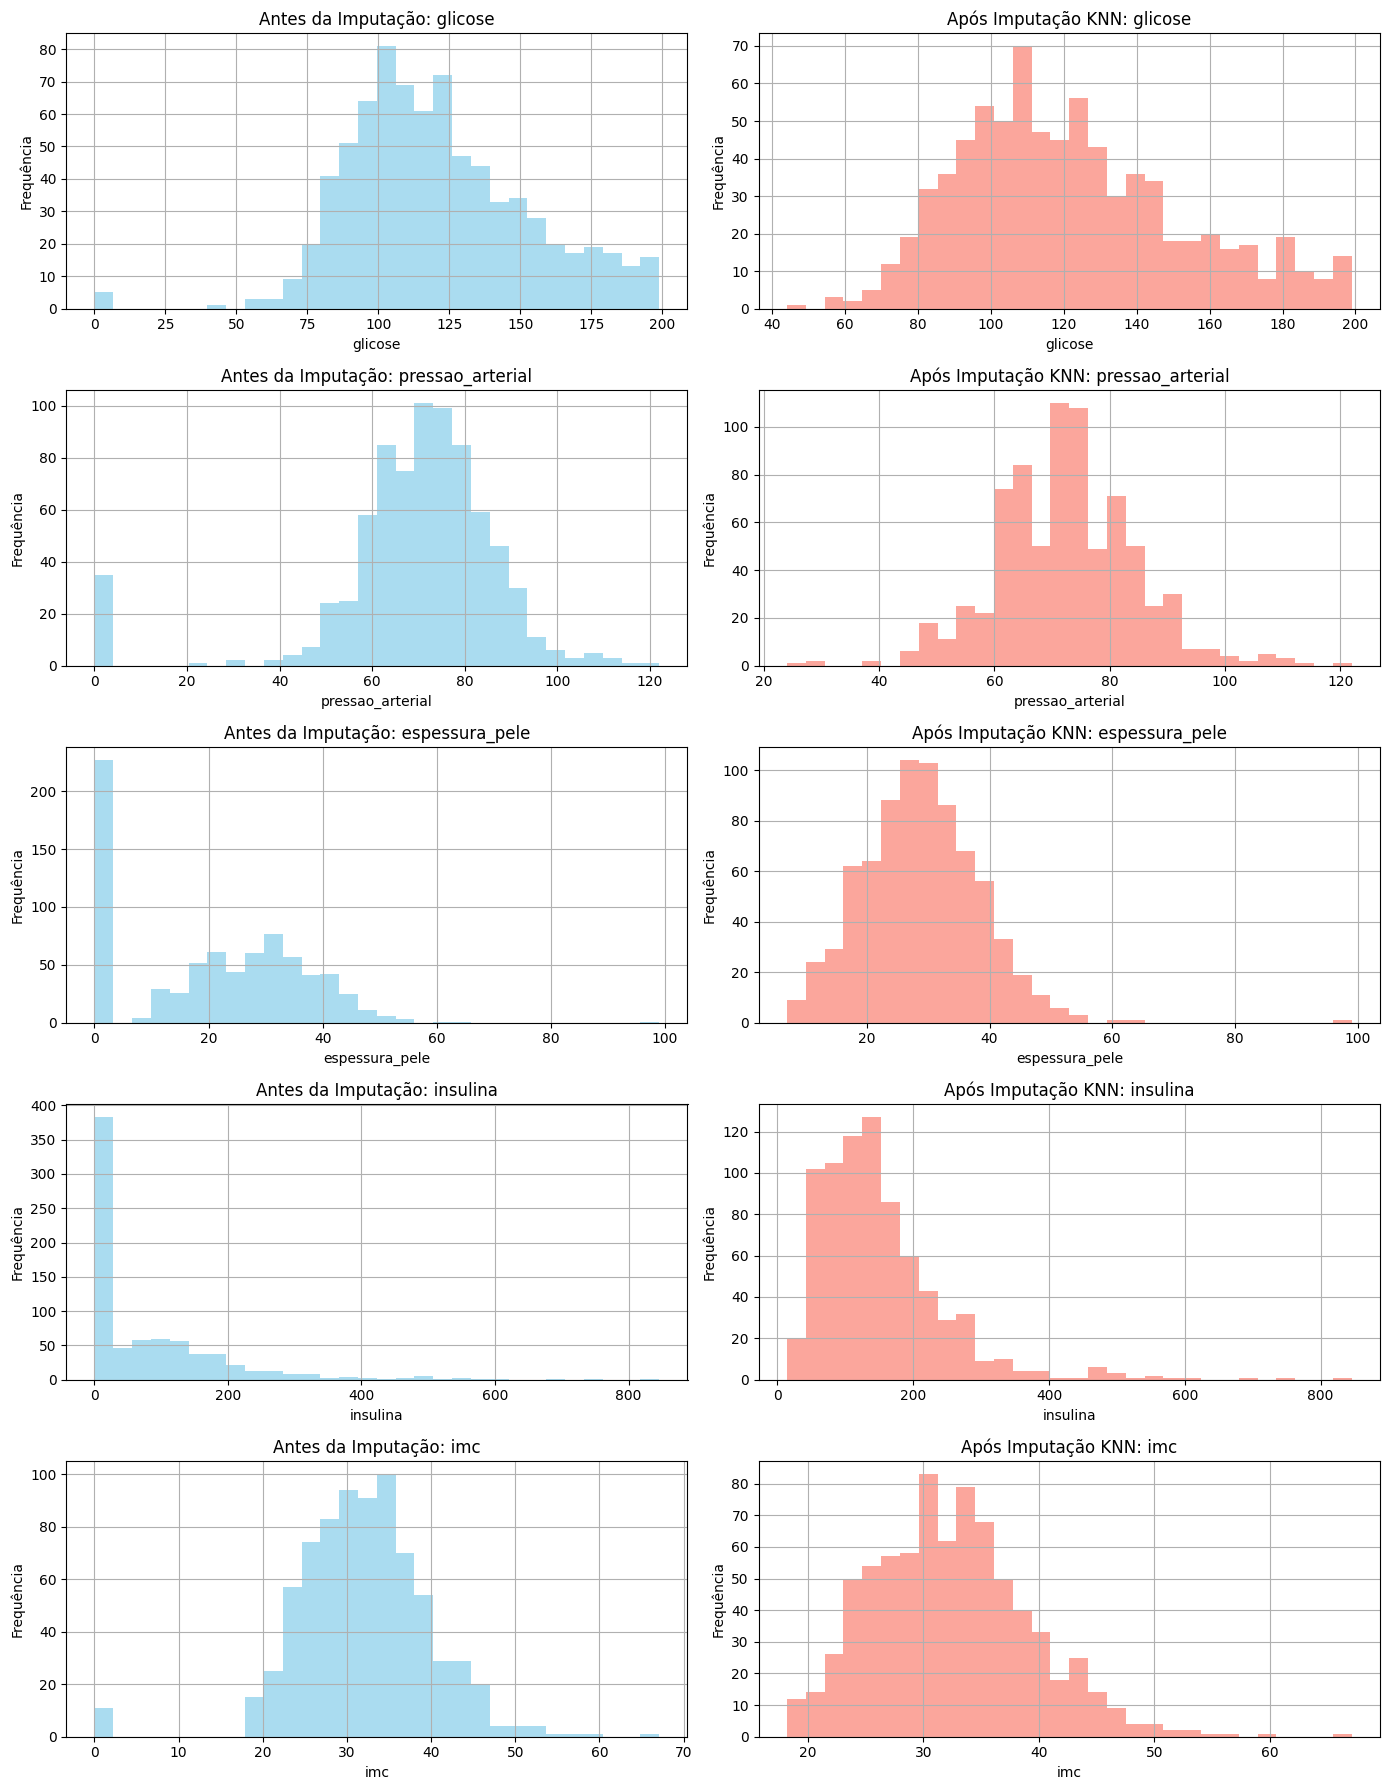

In [17]:
# Colunas onde zero é considerado ausente
colunas_ausentes = ['glicose', 'pressao_arterial', 'espessura_pele', 'insulina', 'imc']
diabetes_knn = df.copy()
diabetes_knn[colunas_ausentes] = diabetes_knn[colunas_ausentes].replace(0, np.nan)

# Aplicar KNNImputer
imputer = KNNImputer(n_neighbors=10)
diabetes_knn[colunas_ausentes] = imputer.fit_transform(diabetes_knn[colunas_ausentes])

# Comparação das distribuições antes e depois da imputação KNN
fig, axes = plt.subplots(5, 2, figsize=(14, 18))
colunas_ausentes = ['glicose', 'pressao_arterial', 'espessura_pele', 'insulina', 'imc']

for i, coluna in enumerate(colunas_ausentes):
    # Antes da imputação
    df[coluna].hist(bins=30, ax=axes[i, 0], color='skyblue', alpha=0.7)
    axes[i, 0].set_title('Antes da Imputação: ' + coluna)
    axes[i, 0].set_xlabel(coluna)
    axes[i, 0].set_ylabel('Frequência')
    # Depois da imputação
    diabetes_knn[coluna].hist(bins=30, ax=axes[i, 1], color='salmon', alpha=0.7)
    axes[i, 1].set_title('Após Imputação KNN: ' + coluna)
    axes[i, 1].set_xlabel(coluna)
    axes[i, 1].set_ylabel('Frequência')

plt.tight_layout()

# caminho_no_drive = '/content/drive/MyDrive/Estatística (Faculdade)/5 Período/Redes Neurais/Trabalho P1/histogramas_knn.png'
# plt.savefig(caminho_no_drive, dpi=300, bbox_inches='tight')

plt.show()

Antes da imputação, observavam-se picos em zero nas distribuições de **glicose**, **pressão arterial**, **espessura da pele**, **insulina** e **IMC**, o que indicava a presença de dados ausentes ou não medidos.

Após a imputação, esses picos desapareceram, resultando em distribuições mais suaves e realistas, que refletem de forma mais precisa a variabilidade fisiológica esperada para cada uma dessas variáveis.

Ao executar o modelo de rede neural MLP, os resultados obtidos com e sem a imputação serão analisados e comparados para avaliar o impacto do tratamento dos dados

O código abaixo tem como objetivo visualizar as matrizes de correlação das variáveis explicativas dos conjuntos de dados com e sem a imputação via KNN.

Para facilitar a interpretação e evitar redundância, é utilizada uma "máscara" que oculta a parte superior da matriz, exibindo apenas a porção triangular inferior, incluindo a diagonal.

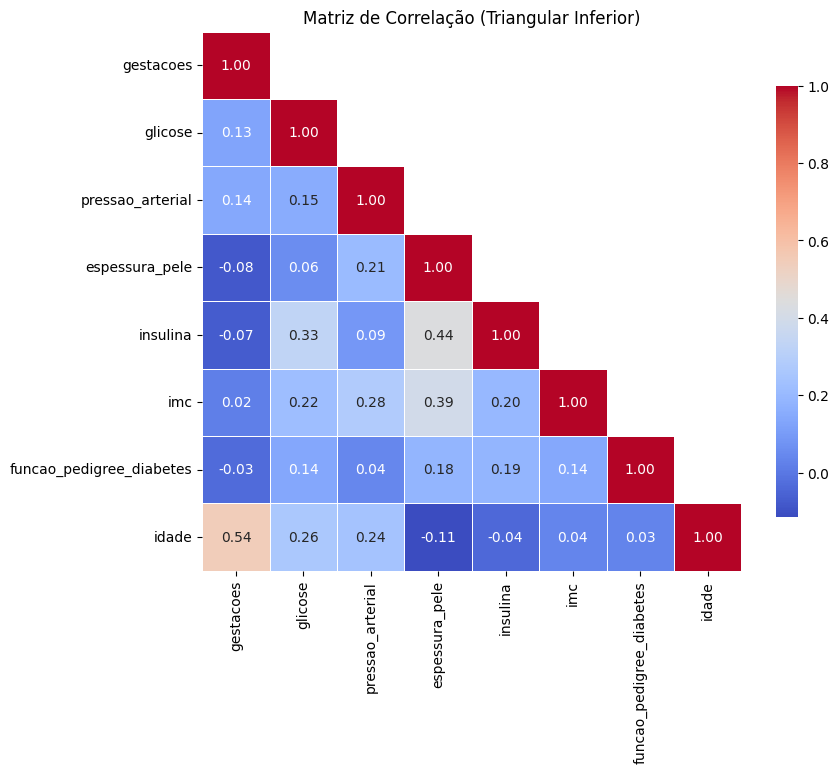

In [18]:
# Remover a coluna 'outcome' da matriz de correlação
df_corr = df.drop('outcome', axis=1).corr()

# Criar uma máscara para exibir apenas a parte triangular inferior e a diagonal
mask = np.triu(np.ones_like(df_corr, dtype=bool), k=1)  # True para a parte superior (acima da diagonal)

plt.figure(figsize=(9, 7))
sns.heatmap(df_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação (Triangular Inferior)')

# caminho_no_drive = '/content/drive/MyDrive/Estatística (Faculdade)/5 Período/Redes Neurais/Trabalho P1/df_corr_sem_knn.png'
# plt.savefig(caminho_no_drive, dpi=300, bbox_inches='tight')

plt.show()

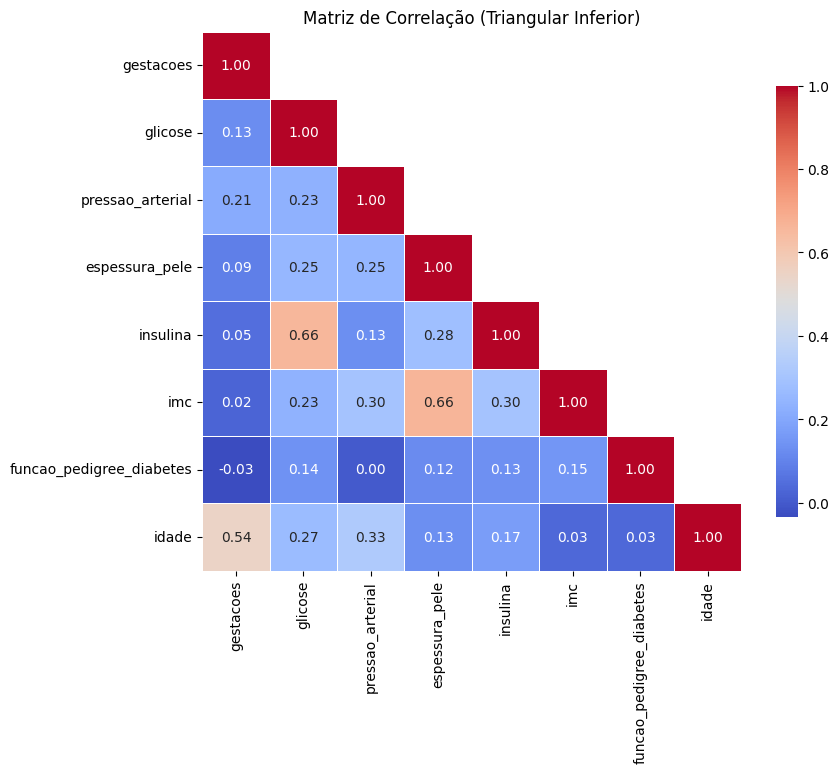

In [19]:
# Remover a coluna 'outcome' da matriz de correlação
df_corr = diabetes_knn.drop('outcome', axis=1).corr()

# Criar uma máscara para exibir apenas a parte triangular inferior e a diagonal
mask = np.triu(np.ones_like(df_corr, dtype=bool), k=1)  # True para a parte superior (acima da diagonal)

plt.figure(figsize=(9, 7))
sns.heatmap(df_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação (Triangular Inferior)')

# caminho_no_drive = '/content/drive/MyDrive/Estatística (Faculdade)/5 Período/Redes Neurais/Trabalho P1/df_corr.png'
# plt.savefig(caminho_no_drive, dpi=300, bbox_inches='tight')

plt.show()

As maiores correlações observadas foram entre espessura da pele e IMC e entre glicose e insulina, ambas com coeficiente de 0,66. Isso indica que valores mais altos de espessura da pele estão associados a IMC mais elevados, e que níveis mais altos de glicose tendem a vir acompanhados de maiores concentrações de insulina. Tais relações não estavam esclarecidas antes do processo de imputação via KNN.

Além disso, há uma correlação significativa (0.54) entre idade e gestações, pois mulheres mais velhas tendem a ter mais gestações.

As demais correlações são baixas, indicando independência entre as variáveis, o que é bom para modelos preditivos.

O código a seguir apresenta a distribuição do **atributo-alvo** ('outcome'), exibindo a contagem e a proporção de indivíduos diabéticos e não diabéticos na base de dados por meio de gráficos de barras e pizza.

=== DISTRIBUIÇÃO DA VARIÁVEL TARGET ===

Contagem por classe:
Não diabético (0): 500
Diabético (1): 268



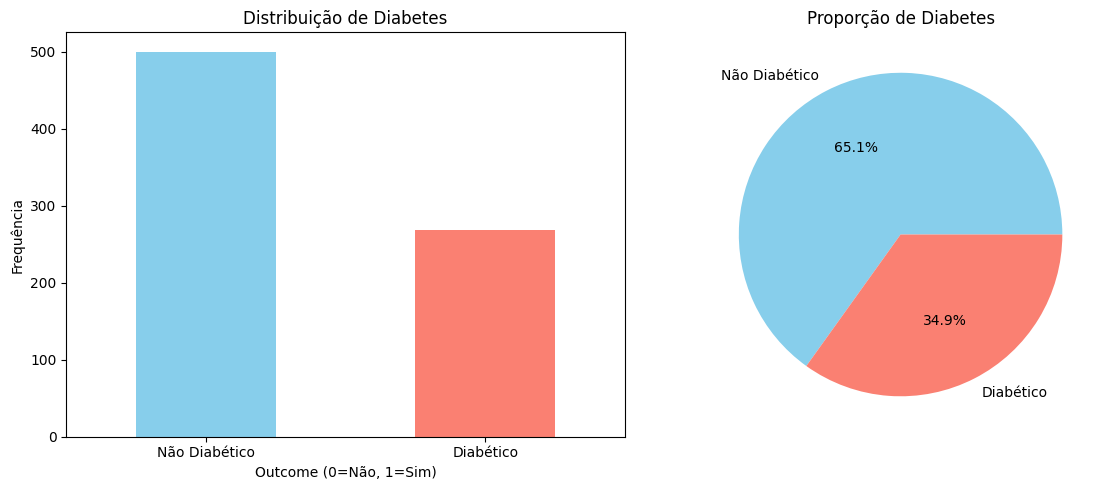

In [20]:
# Distribuição da variável target (outcome)
print("=== DISTRIBUIÇÃO DA VARIÁVEL TARGET ===")
outcome_counts = df['outcome'].value_counts()
print("\nContagem por classe:")
print("Não diabético (0):", outcome_counts[0])
print("Diabético (1):", outcome_counts[1], end="\n\n")

# Visualizar distribuição do target
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
outcome_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Distribuição de Diabetes')
ax1.set_xlabel('Outcome (0=Não, 1=Sim)')
ax1.set_ylabel('Frequência')
ax1.set_xticklabels(['Não Diabético', 'Diabético'], rotation=0)

# Gráfico de pizza
ax2.pie(outcome_counts.values, labels=['Não Diabético', 'Diabético'],
        autopct='%1.1f%%', colors=['skyblue', 'salmon'])
ax2.set_title('Proporção de Diabetes')

plt.tight_layout()

# caminho_no_drive = '/content/drive/MyDrive/Estatística (Faculdade)/5 Período/Redes Neurais/Trabalho P1/proporcao_y.png'
# plt.savefig(caminho_no_drive, dpi=300, bbox_inches='tight')

plt.show()

Como podemos observar acima, Do total de participantes, 500 pessoas (65,1%) não têm diabetes, enquanto as 268 pessoas restantes (34,9%) têm a condição.

O dataset está relativamente balanceado, mas há mais casos negativos do que positivos. Isso é importante para modelagem, pois pode influenciar métricas de avaliação e a necessidade de técnicas para balanceamento de classes.

# MLP (Multilayer Perceptron)

**Normalização:**

O código a seguir aplica a normalização MinMax para escalar as variáveis independentes entre 0 e 1.

A normalização é essencial, pois garante que todas as variáveis contribuam de forma equilibrada no processo de aprendizado, melhorando a convergência e o desempenho do modelo.

In [21]:
# Separar as variáveis explicativas e a variável alvo
df_features = diabetes_knn.drop('outcome', axis=1)
df_target = diabetes_knn['outcome']

# Aplicar MinMaxScaler para normalizar os dados entre 0 e 1
scaler = MinMaxScaler()
df_features_normalized = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

# Juntar novamente com a coluna outcome
df_knn_normalized = pd.concat([df_features_normalized, df_target], axis=1)

display(df_knn_normalized.head())



,gestacoes,glicose,pressao_arterial,espessura_pele,insulina,imc,funcao_pedigree_diabetes,idade,outcome
0,0.352941,0.670968,0.489796,0.304348,0.219591,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.065385,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.231522,0.325120,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1


Definindo os conjuntos de **treino** e **teste**:

In [22]:
# Definindo os dados
X = df_knn_normalized.drop('outcome', axis=1).values
y = df_knn_normalized['outcome'].values

# Dividir o conjunto de dados em treinamento e teste com amostragem estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

O código a seguir calcula pesos automáticos para classes desbalanceadas em machine learning, usando compute_class_weight do scikit-learn. Ele atribui pesos maiores às classes minoritárias e menores às majoritárias, evitando viés no modelo. O resultado é armazenado em um dicionário e exibido, sendo essencial para melhorar a precisão em problemas com distribuição desigual de dados.

In [23]:
# Calcular os pesos das classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print("peso das classes")
print(class_weights_dict)

# Calcular pesos das classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)

peso das classes
{0: np.float64(0.7671428571428571), 1: np.float64(1.4358288770053476)}
{0: np.float64(0.7671428571428571), 1: np.float64(1.4358288770053476)}


O código abaixo apresenta um ciclo robusto de treinamento e validação de modelos de classificação MLP. Inicia-se com a validação cruzada K-Fold (5 folds), garantindo a generalização do modelo e evitando overfitting através do Early Stopping.

Em cada fold, métricas chave como acurácia, precisão e recall são coletadas, e o modelo com a menor loss de validação é preservado. Posteriormente, o código otimiza o threshold de classificação, testando valores para maximizar o F1-score.

Finaliza-se com a avaliação do modelo e do threshold otimizado em um conjunto de teste independente, confirmando seu desempenho em dados inéditos.

In [27]:
# Lista para armazenar os 10 melhores modelos (acurácia, config, pesos)
# Usamos um heap para manter a lista ordenada de forma eficiente
top_10_models = []

# Mapeamento de inteiros para funções de ativação
activation_map = {0: 'relu', 1: 'elu', 2: 'swish'}

# 1. DEFINIÇÃO DA FUNÇÃO OBJETIVO PARA OTIMIZAÇÃO BAYESIANA
def black_box_function(**params):
    """
    Função que a Otimização Bayesiana irá avaliar.
    Constrói, treina (com validação cruzada) e avalia um modelo de NN.
    Retorna a acurácia média de validação para ser maximizada.
    """
    # Converte os parâmetros de float/numérico para os tipos corretos
    num_hidden_layers = int(params['num_layers'])

    # Extrai os parâmetros das camadas que serão usadas
    neurons_per_layer = [int(params[f'neurons_layer_{i+1}']) for i in range(num_hidden_layers)]
    activations_per_layer = [activation_map[int(params[f'activation_layer_{i+1}'])] for i in range(num_hidden_layers)]

    print(f"--- Testando Arquitetura ---")
    print(f"Camadas: {num_hidden_layers}, Neurônios: {neurons_per_layer}, Ativações: {activations_per_layer}")

    # Configuração da validação cruzada
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_per_fold = []
    best_val_loss = np.inf
    best_model_for_this_run = None

    # Configuração do Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)

    # Loop de validação cruzada
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Criar o modelo MLP dinamicamente
        model = Sequential()
        # Primeira camada oculta com input_dim
        model.add(Dense(neurons_per_layer[0], input_dim=X_train.shape[1], activation=activations_per_layer[0]))
        # Demais camadas ocultas
        for i in range(1, num_hidden_layers):
            model.add(Dense(neurons_per_layer[i], activation=activations_per_layer[i]))
        # Camada de saída
        model.add(Dense(1, activation='sigmoid'))

        # Compilar o modelo
        model.compile(loss=BinaryCrossentropy(), optimizer=Adam(), metrics=['accuracy', Precision(), Recall()])

        # Treinar o modelo
        model.fit(X_train_fold, y_train_fold, epochs=150, batch_size=10,
                  validation_data=(X_val_fold, y_val_fold),
                  class_weight=class_weights_dict, callbacks=[early_stopping], verbose=0)

        # Avaliar o modelo na validação atual
        scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        accuracy_per_fold.append(scores[1]) # Acurácia

        # Salva o melhor modelo DENTRO da validação cruzada (baseado na menor perda)
        if scores[0] < best_val_loss:
            best_val_loss = scores[0]
            # Salvamos a configuração e os pesos para poder recriá-lo depois
            best_model_config = model.get_config()
            best_model_weights = model.get_weights()

    mean_accuracy = np.mean(accuracy_per_fold)
    print(f"Acurácia Média de Validação: {mean_accuracy:.4f}\n")

    # 2. LÓGICA PARA ARMAZENAR OS 10 MELHORES MODELOS
    # O heap em Python é um min-heap, então guardamos (-acurácia) para simular um max-heap
    if len(top_10_models) < 10:
        heapq.heappush(top_10_models, (mean_accuracy, best_model_config, best_model_weights))
    else:
        # Se o modelo atual for melhor que o pior dos 10 melhores, substitua-o
        heapq.heappushpop(top_10_models, (mean_accuracy, best_model_config, best_model_weights))

    return mean_accuracy


# 3. DEFINIÇÃO DO ESPAÇO DE BUSCA DE HIPERPARÂMETROS (pbounds)
pbounds = {
    'num_layers': (1, 5.99),  # de 1 a 5 camadas (usamos 5.99 para incluir o 5 após o int())

    # Parâmetros para até 5 camadas
    'neurons_layer_1': (4, 51.99),
    'activation_layer_1': (0, 2.99), # 0: relu, 1: elu, 2: swish

    'neurons_layer_2': (4, 51.99),
    'activation_layer_2': (0, 2.99),

    'neurons_layer_3': (4, 51.99),
    'activation_layer_3': (0, 2.99),

    'neurons_layer_4': (4, 51.99),
    'activation_layer_4': (0, 2.99),

    'neurons_layer_5': (4, 51.99),
    'activation_layer_5': (0, 2.99),
}

# 4. EXECUÇÃO DA OTIMIZAÇÃO BAYESIANA
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=42,
    verbose=2 # 2 para detalhes sobre a busca, 1 para resumo, 0 para silencioso
)

# Inicia a busca
# init_points: Número de passos de exploração aleatória inicial.
# n_iter: Número de passos de otimização bayesiana.
print("--- Iniciando a Busca de Arquitetura de Rede Neural (NAS) ---")
optimizer.maximize(
    init_points=5, # 5 iterações aleatórias para explorar o espaço
    n_iter=25      # 25 iterações guiadas pela otimização bayesiana
)

# 5. RESULTADOS
print("\n--- Busca Finalizada ---")
print("\nMelhor combinação de hiperparâmetros encontrada:")
print(optimizer.max)

# Exibir os 10 melhores modelos encontrados
print("\n--- Top 10 Melhores Modelos Encontrados (ordenados por acurácia) ---")
# Ordena a lista final em ordem decrescente de acurácia
sorted_top_10 = sorted(top_10_models, key=lambda x: x[0], reverse=True)

for i, (accuracy, config, weights) in enumerate(sorted_top_10):
    print(f"\n--- Rank {i+1} ---")
    print(f"Acurácia Média de Validação: {accuracy:.5f}")

    # Recria o modelo para exibir a arquitetura
    model_clone = Sequential.from_config(config)
    num_layers_model = len(model_clone.layers) -1 # subtrai a camada de saída
    print(f"Arquitetura:")
    print(f"  - Número de Camadas Ocultas: {num_layers_model}")
    for j, layer in enumerate(model_clone.layers):
        if j < num_layers_model: # Camadas ocultas
            layer_config = layer.get_config()
            print(f"    - Camada {j+1}: {layer_config['units']} neurônios, ativação='{layer_config['activation']}'")
    print(f"    - Camada de Saída: {model_clone.layers[-1].get_config()['units']} neurônio, ativação='sigmoid'")
    # Os pesos (`weights`) estão salvos e podem ser carregados no `model_clone`
    # Ex: model_clone.set_weights(weights) para usar o modelo para previsões.

--- Iniciando a Busca de Arquitetura de Rede Neural (NAS) ---
|   iter    |  target   | num_la... | neuron... | activa... | neuron... | activa... | neuron... | activa... | neuron... | activa... | neuron... | activa... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
--- Testando Arquitetura ---
Camadas: 2, Neurônios: [49, 32], Ativações: ['swish', 'relu']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

In [ ]:
# Verifica se a lista de melhores modelos não está vazia
if sorted_top_10:
    # 1. Extrai a configuração e os pesos do melhor modelo (o primeiro da lista)
    best_accuracy, best_config, best_weights = sorted_top_10[0]

    # 2. Recria a arquitetura do modelo a partir da configuração salva
    best_model = tf.keras.models.Sequential.from_config(best_config)

    # 3. Carrega os pesos treinados no modelo recriado
    best_model.set_weights(best_weights)

    # 4. Recompila o modelo para que ele possa ser usado para avaliação ou predição.
    #    É importante usar os mesmos parâmetros da compilação original.
    best_model.compile(loss=BinaryCrossentropy(), optimizer=Adam(), metrics=['accuracy', Precision(), Recall()])

    print("\n✅ O melhor modelo foi carregado com sucesso na variável 'best_model'.")
    print(f"   Acurácia de Validação Cruzada deste modelo: {best_accuracy:.5f}")

    print("\nResumo do 'best_model':")
    best_model.summary()

else:
    print("\n⚠️ Nenhum modelo foi encontrado durante a otimização. A variável 'best_model' não foi criada.")


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Função para avaliar com threshold e calcular falsos negativos
def evaluate_with_threshold(model, X, y, threshold=0.5):
    y_pred_proba = model.predict(X, verbose=0)
    y_pred = (y_pred_proba >= threshold).astype(int)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    return accuracy, precision, recall, f1

# Thresholds a serem testados
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

print("\nAvaliando diferentes thresholds no conjunto de validação:")
best_threshold = None
# best_recall = 0
# best_accuracy = 0
best_f1 = 0
# best_precision = 0
threshold_metrics = []  # Para armazenar métricas de todos os thresholds

for threshold in thresholds:
    # Calcular métricas médias para todos os folds com este threshold
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    for train_index, val_index in kf.split(X_train):
        X_val_fold = X_train[val_index]
        y_val_fold = y_train[val_index]

        acc, prec, rec, f1,  = evaluate_with_threshold(best_model, X_val_fold, y_val_fold, threshold)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1s)

    # Armazenar métricas para este threshold
    threshold_metrics.append({
        'threshold': threshold,
        'accuracy': avg_accuracy,
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1,
    })

    print(f"\nThreshold: {threshold:.1f}")
    print(f"  Acurácia média: {avg_accuracy:.4f}")
    print(f"  Precisão média: {avg_precision:.4f}")
    print(f"  Recall médio: {avg_recall:.4f}")
    print(f"  F1-score médio: {avg_f1:.4f}")

    # if avg_recall > best_recall:
    #     best_recall = avg_recall
    #     best_threshold = threshold

    # if avg_accuracy > best_accuracy:
    #     best_accuracy = avg_accuracy
    #     best_threshold = threshold

    # if avg_precision > best_precision:
    #     best_precision = avg_precision
    #     best_threshold = threshold

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_threshold = threshold

# Exibir métricas de todos os thresholds em uma tabela
print("\nResumo dos thresholds testados:")
print("{:<10} {:<10} {:<10} {:<10} {:<10}".format(
    "Threshold", "Acurácia", "Precisão", "Recall", "F1-score"))
for metrics in threshold_metrics:
    print("{:<10.1f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        metrics['threshold'], metrics['accuracy'], metrics['precision'],
        metrics['recall'], metrics['f1']))

print(f"\nMelhor threshold encontrado: {best_threshold:.1f} (Best F1-Score: {best_f1:.4f})")
# print(f"\nMelhor threshold encontrado: {best_threshold:.1f} (Best Accuracy: {best_accuracy:.4f})")
# print(f"\nMelhor threshold encontrado: {best_threshold:.1f} (Best Precision: {best_precision:.4f})")
# print(f"\nMelhor threshold encontrado: {best_threshold:.1f} (Best Recall: {best_recall:.4f})")

# Avaliar no conjunto de teste com o melhor threshold
print("\nAvaliação no conjunto de teste com o melhor threshold:")
test_acc, test_prec, test_rec, test_f1 = evaluate_with_threshold(best_model, X_test, y_test, best_threshold)
print(f"  Acurácia: {test_acc:.4f}")
print(f"  Precisão: {test_prec:.4f}")
print(f"  Recall: {test_rec:.4f}")
print(f"  F1-score: {test_f1:.4f}")

# Adicione este trecho para plotar a matriz de confusão
y_test_pred_proba = best_model.predict(X_test, verbose=0)
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

# # Calcular a matriz de confusão
# print(confusion_matrix(y_test, y_test_pred))

In [ ]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)

# Criar uma figura
fig, ax = plt.subplots(figsize=(6, 6))

# Exibir a matriz de confusão com cores
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax, colorbar=False)


# Ajustar título e layout
ax.set_title('Matriz de Confusão', fontsize=14)
plt.tight_layout()
plt.show()